# Helping Businesses expand into Chicago Market with Data-Driven Insights

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
from shapely.geometry import shape, Point, Polygon, MultiPolygon
import fiona
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

## The Business Problem

Abandoned-vacanat buildings and sanitation complaints are regarded as a hazard, threatening the cleanliness and overall desirability of the neighborhood.

## 311_Service_Requests_Sanitation_Code_Complaints_Historical

### Load the dataset - 311_Service_Requests_Sanitation_Code_Complaints_Historical

In [ ]:
df1 = pd.read_csv("311_Service_Requests_Sanitation_Code_Complaints_Historical.csv",
                  parse_dates  =['Creation Date','Completion Date'])

df1.sort_values(by='Creation Date').head(2)

,Creation Date,Status,Completion Date,Service Request Number,Type of Service Request,What is the Nature of this Code Violation?,Street Address,ZIP Code,X Coordinate,Y Coordinate,Ward,Police District,Community Area,Latitude,Longitude,Location
103853,2000-01-03,Completed,2011-03-28,00-00002724,Sanitation Code Violation,NaN,4836 S PAULINA,NaN,1.165826e+06,1.872636e+06,20.0,9.0,61.0,41.806098,-87.667336,"(41.806097966311, -87.667335574334)"
87485,2000-01-03,Completed,2011-03-28,00-00002178,Sanitation Code Violation,NaN,4837 S DAMEN,NaN,1.163839e+06,1.872588e+06,20.0,9.0,61.0,41.806008,-87.674623,"(41.806007743198, -87.67462318811)"
83491,2000-01-03,Completed,2011-03-28,00-00002158,Sanitation Code Violation,NaN,4853 S WOOD,NaN,1.165167e+06,1.872509e+06,20.0,9.0,61.0,41.805763,-87.669757,"(41.805763435869, -87.669756725682)"
141693,2000-01-03,Completed,2011-03-28,00-00004301,Sanitation Code Violation,NaN,4816 S WOOD,NaN,1.165160e+06,1.872757e+06,20.0,9.0,61.0,41.806443,-87.669775,"(41.806443441427, -87.669774741291)"
63346,2000-01-03,Completed,2011-03-28,00-00002488,Sanitation Code Violation,NaN,4959 S JUSTINE,NaN,1.166843e+06,1.871824e+06,20.0,9.0,61.0,41.803849,-87.663626,"(41.803848770876, -87.66362637554)"


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152664 entries, 0 to 152663
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Creation Date                               152664 non-null  datetime64[ns]
 1   Status                                      152664 non-null  object        
 2   Completion Date                             152482 non-null  datetime64[ns]
 3   Service Request Number                      152664 non-null  object        
 4   Type of Service Request                     152664 non-null  object        
 5   What is the Nature of this Code Violation?  147436 non-null  object        
 6   Street Address                              152664 non-null  object        
 7   ZIP Code                                    152480 non-null  float64       
 8   X Coordinate                                152636 non-null  float64      

### Dataset cleaning - part1

In [ ]:
df1 = df1.drop(columns=['Type of Service Request','X Coordinate','Y Coordinate','Location'])
df1 = df1.rename({ 'What is the Nature of this Code Violation?':'Nature of Code Violation',
                   'Community Area': 'Community Id'},axis=1) 

df1.head()

,Creation Date,Status,Completion Date,Service Request Number,Nature of Code Violation,Street Address,ZIP Code,Ward,Police District,Community Id,Latitude,Longitude
0,2017-08-07,Completed - Dup,2017-10-11,17-05238441,Dog feces in yard,1301 S FAIRFIELD AVE,60608.0,28.0,10.0,29.0,41.864611,-87.694585
1,2017-09-17,Completed,2017-10-11,17-06208608,Overflowing carts,6327 S KENNETH AVE,60629.0,13.0,8.0,65.0,41.777870,-87.733727
2,2017-10-05,Completed,2017-10-11,17-06678788,Garbage in alley,3020 W MONTROSE AVE,60618.0,33.0,17.0,14.0,41.961214,-87.704204
3,2017-08-21,Completed,2017-10-11,17-05591233,Garbage in yard,1500 S DAMEN AVE,60608.0,28.0,12.0,28.0,41.861249,-87.676109
4,2017-09-23,Completed,2017-10-11,17-06370432,Construction Site Cleanliness/Fence,6442 S CENTRAL AVE,60638.0,13.0,8.0,64.0,41.775189,-87.761614


In [ ]:
features = ['Nature of Code Violation','Street Address','ZIP Code','Ward','Police District','Community Id','Latitude','Longitude']
df1 = df1.dropna(subset=features)
df1.isnull().sum()

Creation Date                 0
Status                        0
Completion Date             181
Service Request Number        0
Nature of Code Violation      0
Street Address                0
ZIP Code                      0
Ward                          0
Police District               0
Community Id                  0
Latitude                      0
Longitude                     0
dtype: int64

In [ ]:
df1[df1['Completion Date'].isnull()].Status.value_counts()

Open          121
Open - Dup     60
Name: Status, dtype: int64

In [ ]:
df1 = df1[df1.Status == 'Completed']
df1 = df1.drop(columns='Status')
df1.isnull().sum()

Creation Date               0
Completion Date             0
Service Request Number      0
Nature of Code Violation    0
Street Address              0
ZIP Code                    0
Ward                        0
Police District             0
Community Id                0
Latitude                    0
Longitude                   0
dtype: int64

In [ ]:
df1 = df1[df1['Creation Date'].dt.year >= 2012]

int_cols = ['ZIP Code','Ward','Police District','Community Id']
df1[int_cols] = df1[int_cols].fillna(0.0).astype(int)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124144 entries, 1 to 152662
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Creation Date             124144 non-null  datetime64[ns]
 1   Completion Date           124144 non-null  datetime64[ns]
 2   Service Request Number    124144 non-null  object        
 3   Nature of Code Violation  124144 non-null  object        
 4   Street Address            124144 non-null  object        
 5   ZIP Code                  124144 non-null  int64         
 6   Ward                      124144 non-null  int64         
 7   Police District           124144 non-null  int64         
 8   Community Id              124144 non-null  int64         
 9   Latitude                  124144 non-null  float64       
 10  Longitude                 124144 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)
memory usag

In [ ]:
ids = df1['Service Request Number']
dups = df1[ids.isin(ids[ids.duplicated()])].sort_values(by='Service Request Number')
print(dups.head())
print(dups.shape)

       Creation Date Completion Date Service Request Number  \
103228    2012-07-06      2012-07-27            12-01209013   
113136    2012-07-06      2013-11-20            12-01209013   
44607     2012-07-06      2013-11-20            12-01209172   
61554     2012-07-06      2012-07-27            12-01209172   
20338     2013-03-25      2013-04-05            13-00333860   

       Nature of Code Violation           Street Address  ZIP Code  Ward  \
103228                    Other         3612 N DAMEN AVE     60618    47   
113136                    Other         3612 N DAMEN AVE     60618    47   
44607         Dog feces in yard  1919 W BELLE PLAINE AVE     60613    47   
61554         Dog feces in yard  1919 W BELLE PLAINE AVE     60613    47   
20338           Garbage in yard         4959 W ARGYLE ST     60630    45   

        Police District  Community Id   Latitude  Longitude  
103228               19             5  41.947220 -87.678563  
113136               19             5  4

In [ ]:
df1 = df1.sort_values('Completion Date', ascending=False).drop_duplicates('Service Request Number').sort_index()
df1.shape

(123358, 11)

### EDA - part 1

In [ ]:
cols = df1.columns[2:9]
for col in cols:
    count = df1[col].value_counts(sort=True)
    print(col,":",len(count))

Service Request Number : 123358
Nature of Code Violation : 9
Street Address : 80948
ZIP Code : 59
Ward : 50
Police District : 26
Community Id : 77


In [ ]:
df1.drop(df1.index[df1['Nature of Code Violation'] == 'Other'], inplace=True)

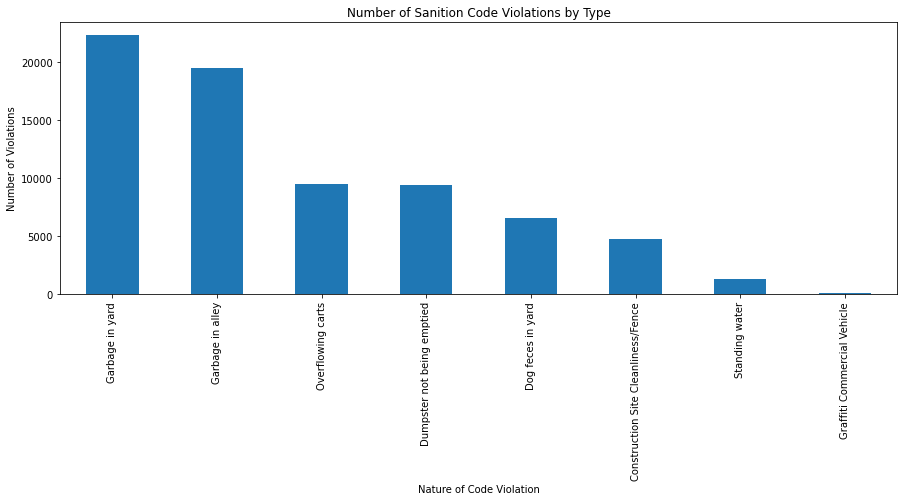

In [ ]:
df1['Nature of Code Violation'].value_counts().plot(kind='bar', figsize=(15,5))
plt.title("Number of Sanition Code Violations by Type")
plt.ylabel('Number of Violations')
plt.xlabel('Nature of Code Violation');

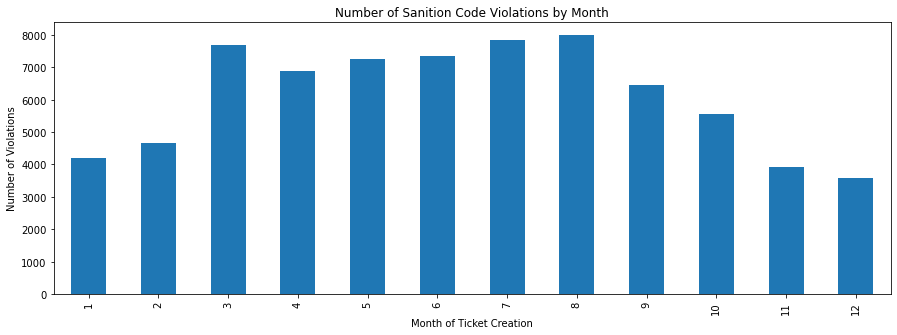

In [ ]:
df1.groupby(df1['Creation Date'].dt.month).size().plot(kind = 'bar', figsize=(15,5))
plt.title("Number of Sanition Code Violations by Month")
plt.ylabel('Number of Violations')
plt.xlabel('Month of Ticket Creation');

In [ ]:
df1['Resolution Time'] = abs(df1['Creation Date'] - df1['Completion Date'])

In [ ]:
(df1.groupby('Nature of Code Violation').agg({
    'Resolution Time':['mean','median','min','max']
}))

Resolution Time                \
                                                          mean median    min   
Nature of Code Violation                                                       
Construction Site Cleanliness/Fence            6 days 09:00:00 3 days 0 days   
Dog feces in yard                    8 days 01:31:58.562874251 4 days 0 days   
Dumpster not being emptied           6 days 11:10:09.477366691 3 days 0 days   
Garbage in alley                     7 days 20:29:22.268803945 3 days 0 days   
Garbage in yard                     10 days 02:10:06.995515695 5 days 0 days   
Graffiti Commercial Vehicle          4 days 16:25:15.789473684 2 days 0 days   
Overflowing carts                    7 days 05:22:01.288692356 3 days 0 days   
Standing water                       6 days 09:29:45.190725504 3 days 0 days   

                                              
                                         max  
Nature of Code Violation                      
Construction Site Cleanliness/Fence 145 days  
Dog feces in yard                   502 days  
Dumpster not being emptied          215 days  
Garbage in alley                    301 days  
Garbage in yard                     548 days  
Graffiti Commercial Vehicle          27 days  
Overflowing carts                   213 days  
Standing water                      164 days

In [ ]:
df1['Street Address'].value_counts().nlargest(10)

21 E 120TH ST           92
4048 N MOZART ST        91
4028 N MOZART ST        66
2483 N CLARK ST         61
2485 N CLARK ST         61
2525 N CLARK ST         56
6349 N FAIRFIELD AVE    49
4032 N MOZART ST        44
455 W ST JAMES PL       42
3420 W GRACE ST         41
Name: Street Address, dtype: int64

In [ ]:
gdf1 = gpd.GeoDataFrame(df1,
                       geometry=gpd.points_from_xy(df1.Longitude, df1.Latitude))
gdf1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 73371 entries, 1 to 152662
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   Creation Date             73371 non-null  datetime64[ns] 
 1   Completion Date           73371 non-null  datetime64[ns] 
 2   Service Request Number    73371 non-null  object         
 3   Nature of Code Violation  73371 non-null  object         
 4   Street Address            73371 non-null  object         
 5   ZIP Code                  73371 non-null  int64          
 6   Ward                      73371 non-null  int64          
 7   Police District           73371 non-null  int64          
 8   Community Id              73371 non-null  int64          
 9   Latitude                  73371 non-null  float64        
 10  Longitude                 73371 non-null  float64        
 11  Resolution Time           73371 non-null  timedelta64[ns]


In [ ]:
r = requests.get("https://data.cityofchicago.org/resource/igwz-8jzy.json")
data = r.json()
for d in data:
    d['the_geom'] = shape(d['the_geom'])
community = gpd.GeoDataFrame(data).set_geometry('the_geom')
community.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   the_geom    77 non-null     geometry
 1   perimeter   77 non-null     object  
 2   area        77 non-null     object  
 3   comarea     77 non-null     object  
 4   comarea_id  77 non-null     object  
 5   area_numbe  77 non-null     object  
 6   community   77 non-null     object  
 7   area_num_1  77 non-null     object  
 8   shape_area  77 non-null     object  
 9   shape_len   77 non-null     object  
dtypes: geometry(1), object(9)
memory usage: 6.1+ KB


In [ ]:
drop_cols = ['perimeter','area','comarea','comarea_id','area_numbe','shape_area','shape_len']
community = community.drop(columns=drop_cols)
community = community.rename({
    'community':'name',
    'area_num_1': 'Community Id'}, axis=1) 
community['Community Id'] = community['Community Id'].astype(str).astype(int)

In [ ]:
san_df = gdf1.sjoin(community, how='left')
san_df = san_df.drop(columns=['index_right','Community Id_right'])
san_df = san_df.rename(columns={'Community Id_left': 'Community Id'})
san_df.head()

,Creation Date,Completion Date,Service Request Number,Nature of Code Violation,Street Address,ZIP Code,Ward,Police District,Community Id,Latitude,Longitude,Resolution Time,geometry,name
1,2017-09-17,2017-10-11,17-06208608,Overflowing carts,6327 S KENNETH AVE,60629,13,8,65,41.777870,-87.733727,24 days,POINT (-87.73373 41.77787),WEST LAWN
2,2017-10-05,2017-10-11,17-06678788,Garbage in alley,3020 W MONTROSE AVE,60618,33,17,14,41.961214,-87.704204,6 days,POINT (-87.70420 41.96121),IRVING PARK
3,2017-08-21,2017-10-11,17-05591233,Garbage in yard,1500 S DAMEN AVE,60608,28,12,28,41.861249,-87.676109,51 days,POINT (-87.67611 41.86125),NEAR WEST SIDE
4,2017-09-23,2017-10-11,17-06370432,Construction Site Cleanliness/Fence,6442 S CENTRAL AVE,60638,13,8,64,41.775189,-87.761614,18 days,POINT (-87.76161 41.77519),CLEARING
10,2017-07-14,2017-08-04,17-04636140,Garbage in alley,7212 S 73RD ST ER,60619,8,3,69,41.763603,-87.605521,21 days,POINT (-87.60552 41.76360),GREATER GRAND CROSSING


Now that the two datasets are joined, we can analyze these complaints in terms of community . 

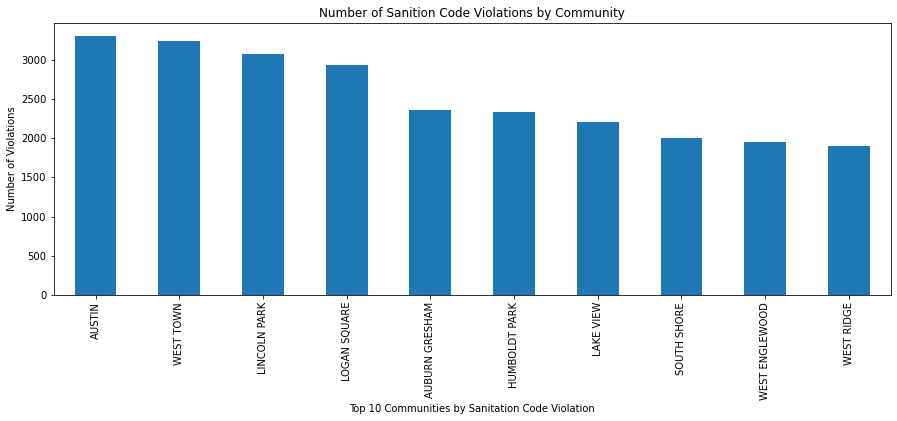

In [ ]:
san_df['name'].value_counts().nlargest(10).plot(kind='bar', figsize=(15,5))
plt.title("Number of Sanition Code Violations by Community")
plt.ylabel('Number of Violations')
plt.xlabel('Top 10 Communities by Sanitation Code Violation');

In [ ]:
top10_community = san_df['name'].value_counts().nlargest(10)
neighborhoods = top10_community.index.tolist()

for n in neighborhoods: 
    df = san_df[san_df['name'] == n]
    top10_type = df['Street Address'].value_counts().nlargest(1)
    print(n,'-', top10_type.index.tolist())

AUSTIN - ['1215 N LAMON AVE']
WEST TOWN - ['1313 W CHICAGO AVE']
LINCOLN PARK - ['2483 N CLARK ST']
LOGAN SQUARE - ['2820 W ARMITAGE AVE']
AUBURN GRESHAM - ['8234 S CARPENTER ST']
HUMBOLDT PARK - ['924 N LAWNDALE AVE']
LAKE VIEW - ['837 W WOLFRAM ST']
SOUTH SHORE - ['7115 S CORNELL AVE']
WEST ENGLEWOOD - ['6926 S JUSTINE ST']
WEST RIDGE - ['6349 N FAIRFIELD AVE']


## 311 Service Requests - Vacant and Abandoned Buildings Reported - Historical

### Load dataset - 311 Service Requests - Vacant and Abandoned Buildings Reported - Historical



In [ ]:
df2 = pd.read_csv("Vacant_and_Abandoned_Buildings.csv",
                  parse_dates = ['DATE SERVICE REQUEST WAS RECEIVED'])

df2.head()

,SERVICE REQUEST TYPE,SERVICE REQUEST NUMBER,DATE SERVICE REQUEST WAS RECEIVED,"LOCATION OF BUILDING ON THE LOT (IF GARAGE, CHANGE TYPE CODE TO BGD).",IS THE BUILDING DANGEROUS OR HAZARDOUS?,IS BUILDING OPEN OR BOARDED?,"IF THE BUILDING IS OPEN, WHERE IS THE ENTRY POINT?",IS THE BUILDING CURRENTLY VACANT OR OCCUPIED?,IS THE BUILDING VACANT DUE TO FIRE?,"ANY PEOPLE USING PROPERTY? (HOMELESS, CHILDEN, GANGS)",...,ADDRESS STREET SUFFIX,ZIP CODE,X COORDINATE,Y COORDINATE,Ward,Police District,Community Area,LATITUDE,LONGITUDE,Location
0,Vacant/Abandoned Building,17-06828959,2017-10-11,Front,NaN,Open,NaN,Vacant,False,False,...,ST,60620.0,1.168783e+06,1.853478e+06,17.0,6.0,71.0,41.753463,-87.657041,"(41.753462703929, -87.657041377513)"
1,Vacant/Abandoned Building,17-06827096,2017-10-11,Front,NaN,Open,FRONT DOOR,Vacant,False,False,...,AVE,60637.0,1.181041e+06,1.861212e+06,20.0,3.0,42.0,41.774412,-87.611883,"(41.774411948175, -87.611883311021)"
2,Vacant/Abandoned Building,17-06818719,2017-10-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,PL,60628.0,1.176047e+06,1.834970e+06,34.0,5.0,49.0,41.702514,-87.630974,"(41.702513512066, -87.630973750337)"
3,Vacant/Abandoned Building,17-06824436,2017-10-11,Rear,NaN,Open,SIDE DOOR,Vacant,True,True,...,AVE,60621.0,1.172283e+06,1.866776e+06,20.0,7.0,68.0,41.789879,-87.643825,"(41.789878552302, -87.643824817919)"
4,Vacant/Abandoned Building,17-06826684,2017-10-11,Front,NaN,Open,FRONT DOOR,Vacant,False,True,...,ST,60628.0,1.175546e+06,1.841922e+06,21.0,5.0,49.0,41.721604,-87.632602,"(41.721604113589, -87.63260226787)"


### Dataset cleaning- part 2

In [ ]:
df2 = df2[df2['DATE SERVICE REQUEST WAS RECEIVED'].dt.year >= 2012]

In [ ]:
df2 = df2[df2.columns[df2.notna().sum()/len(df2) >= 0.3]]
drop_list = ['SERVICE REQUEST TYPE','X COORDINATE','Y COORDINATE']
df2 = df2.drop(columns=drop_list)
df2.columns = df2.columns.str.title()

df2.head()

,Service Request Number,Date Service Request Was Received,"Location Of Building On The Lot (If Garage, Change Type Code To Bgd).",Is Building Open Or Boarded?,"If The Building Is Open, Where Is The Entry Point?",Is The Building Currently Vacant Or Occupied?,Is The Building Vacant Due To Fire?,"Any People Using Property? (Homeless, Childen, Gangs)",Address Street Number,Address Street Direction,Address Street Name,Address Street Suffix,Zip Code,Ward,Police District,Community Area,Latitude,Longitude,Location
0,17-06828959,2017-10-11,Front,Open,NaN,Vacant,False,False,7734.0,S,ADA,ST,60620.0,17.0,6.0,71.0,41.753463,-87.657041,"(41.753462703929, -87.657041377513)"
1,17-06827096,2017-10-11,Front,Open,FRONT DOOR,Vacant,False,False,6624.0,S,RHODES,AVE,60637.0,20.0,3.0,42.0,41.774412,-87.611883,"(41.774411948175, -87.611883311021)"
2,17-06818719,2017-10-11,NaN,NaN,NaN,NaN,NaN,NaN,309.0,W,105TH,PL,60628.0,34.0,5.0,49.0,41.702514,-87.630974,"(41.702513512066, -87.630973750337)"
3,17-06824436,2017-10-11,Rear,Open,SIDE DOOR,Vacant,True,True,5744.0,S,EMERALD,AVE,60621.0,20.0,7.0,68.0,41.789879,-87.643825,"(41.789878552302, -87.643824817919)"
4,17-06826684,2017-10-11,Front,Open,FRONT DOOR,Vacant,False,True,347.0,W,95TH,ST,60628.0,21.0,5.0,49.0,41.721604,-87.632602,"(41.721604113589, -87.63260226787)"


In [ ]:
df2 = df2.rename({
    'Date Service Request Was Received':'Creation Date',
    'Location Of Building On The Lot (If Garage, Change Type Code To Bgd).': 'Location of Building on Lot',
    'If The Building Is Open, Where Is The Entry Point?': 'Entry Point if Open',
    'Community Area': 'Community Id'}, 
    axis=1)

df2.loc[df2['Location of Building on Lot'] == 'Garage','Location of Building on Lot'] = 'BDG'

df2['Location of Building on Lot'].value_counts()

Front    30888
Rear      5842
BDG        963
Name: Location of Building on Lot, dtype: int64

In [ ]:
df2.loc[df2['Is Building Open Or Boarded?'] == 'Boarded', 'Entry Point if Open'] = 'Boarded N/A'
df2 = df2.dropna()
df2['Is Building Open?'] = np.where(df2['Is Building Open Or Boarded?'] != 'Boarded',True, False)
df2['Is Building Vacant'] = np.where(df2['Is The Building Currently Vacant Or Occupied?'] == 'Vacant',True, False)
df2 = df2.drop(columns = ['Is Building Open Or Boarded?','Is The Building Currently Vacant Or Occupied?'])

In [ ]:
bool_cols = ['Is The Building Vacant Due To Fire?',
             'Any People Using Property? (Homeless, Childen, Gangs)']

df2[bool_cols] = df2[bool_cols].astype('bool')

int_cols2 = ['Address Street Number','Zip Code','Ward','Police District','Community Id']
df2[int_cols2] = df2[int_cols2].fillna(0.0).astype(int)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26007 entries, 1 to 65117
Data columns (total 19 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   Service Request Number                                 26007 non-null  object        
 1   Creation Date                                          26007 non-null  datetime64[ns]
 2   Location of Building on Lot                            26007 non-null  object        
 3   Entry Point if Open                                    26007 non-null  object        
 4   Is The Building Vacant Due To Fire?                    26007 non-null  bool          
 5   Any People Using Property? (Homeless, Childen, Gangs)  26007 non-null  bool          
 6   Address Street Number                                  26007 non-null  int64         
 7   Address Street Direction                               26007 non-nu

In [ ]:
address_cols = ['Address Street Number','Address Street Direction','Address Street Name','Address Street Suffix']
df2['Street Address'] = df2[address_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [ ]:
df2 = df2.drop(columns=address_cols)
df2.head()

,Service Request Number,Creation Date,Location of Building on Lot,Entry Point if Open,Is The Building Vacant Due To Fire?,"Any People Using Property? (Homeless, Childen, Gangs)",Zip Code,Ward,Police District,Community Id,Latitude,Longitude,Location,Is Building Open?,Is Building Vacant,Street Address
1,17-06827096,2017-10-11,Front,FRONT DOOR,False,False,60637,20,3,42,41.774412,-87.611883,"(41.774411948175, -87.611883311021)",True,True,6624 S RHODES AVE
3,17-06824436,2017-10-11,Rear,SIDE DOOR,True,True,60621,20,7,68,41.789879,-87.643825,"(41.789878552302, -87.643824817919)",True,True,5744 S EMERALD AVE
4,17-06826684,2017-10-11,Front,FRONT DOOR,False,True,60628,21,5,49,41.721604,-87.632602,"(41.721604113589, -87.63260226787)",True,True,347 W 95TH ST
5,17-06832236,2017-10-11,Front,"FRONT/REAR DOORS, WINDOWS",False,True,60621,6,7,69,41.763662,-87.626774,"(41.763661724785, -87.626773537846)",True,True,60 W 72ND ST
6,17-05167309,2017-08-04,Front,1ST FLOOR WINDOW,False,False,60651,37,25,23,41.903236,-87.725100,"(41.903236038454, -87.725100208587)",True,True,1231 N HARDING AVE


In [ ]:
id1 = df2['Service Request Number']
dups1 = df2[id1.isin(id1[id1.duplicated()])].sort_values(by='Service Request Number')
dups1.shape

(0, 16)

In [ ]:
id2 = df2['Street Address']
dups2 = df2[id2.isin(id2[id2.duplicated()])].sort_values(by='Street Address')
print(dups2.shape)
dups2.head()

(13049, 16)


,Service Request Number,Creation Date,Location of Building on Lot,Entry Point if Open,Is The Building Vacant Due To Fire?,"Any People Using Property? (Homeless, Childen, Gangs)",Zip Code,Ward,Police District,Community Id,Latitude,Longitude,Location,Is Building Open?,Is Building Vacant,Street Address
24335,13-01352600,2013-09-14,Front,FRONT ENTRANCE,False,True,60624,28,11,26,41.881937,-87.725707,"(41.881937438466, -87.725706806075)",True,True,100 N PULASKI RD
51547,15-02061346,2015-05-17,Front,1ST FL,False,False,60624,28,11,26,41.881937,-87.725707,"(41.881937438466, -87.725706806075)",True,True,100 N PULASKI RD
40725,12-01334202,2012-07-25,Front,FRONT,False,True,60624,28,11,26,41.881937,-87.725707,"(41.881937438466, -87.725706806075)",True,True,100 N PULASKI RD
52539,12-01151230,2012-06-26,Front,FRONT WINDOWN,False,True,60624,28,11,26,41.881937,-87.725707,"(41.881937438466, -87.725706806075)",True,True,100 N PULASKI RD
2852,14-00517186,2014-04-10,Front,FRONT DOOR,False,False,60624,28,11,26,41.881937,-87.725707,"(41.881937438466, -87.725706806075)",True,True,100 N PULASKI RD


In [ ]:
df2 = df2.sort_values('Creation Date', ascending=True).drop_duplicates('Street Address').sort_index()
df2.shape

(17786, 16)

In [ ]:
gdf2 = gpd.GeoDataFrame(df2,
                       geometry=gpd.points_from_xy(df2.Longitude, df2.Latitude))
gdf2 = gdf2.drop(columns=['Location'])
gdf2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17786 entries, 4 to 65117
Data columns (total 16 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   Service Request Number                                 17786 non-null  object        
 1   Creation Date                                          17786 non-null  datetime64[ns]
 2   Location of Building on Lot                            17786 non-null  object        
 3   Entry Point if Open                                    17786 non-null  object        
 4   Is The Building Vacant Due To Fire?                    17786 non-null  bool          
 5   Any People Using Property? (Homeless, Childen, Gangs)  17786 non-null  bool          
 6   Zip Code                                               17786 non-null  int64         
 7   Ward                                                   1778

In [ ]:
vacancy_df = gdf2.sjoin(community, how='left')
vacancy_df = vacancy_df.drop(columns=['index_right','Community Id_right'])
vacancy_df = vacancy_df.rename(columns={'Community Id_left': 'Community Id'})
vacancy_df.head()

,Service Request Number,Creation Date,Location of Building on Lot,Entry Point if Open,Is The Building Vacant Due To Fire?,"Any People Using Property? (Homeless, Childen, Gangs)",Zip Code,Ward,Police District,Community Id,Latitude,Longitude,Is Building Open?,Is Building Vacant,Street Address,geometry,name
4,17-06826684,2017-10-11,Front,FRONT DOOR,False,True,60628,21,5,49,41.721604,-87.632602,True,True,347 W 95TH ST,POINT (-87.63260 41.72160),ROSELAND
5,17-06832236,2017-10-11,Front,"FRONT/REAR DOORS, WINDOWS",False,True,60621,6,7,69,41.763662,-87.626774,True,True,60 W 72ND ST,POINT (-87.62677 41.76366),GREATER GRAND CROSSING
8,17-05174699,2017-08-04,Front,REAR DOOR,False,True,60636,16,7,67,41.776772,-87.675056,True,True,6440 S SEELEY AVE,POINT (-87.67506 41.77677),WEST ENGLEWOOD
18,17-05176564,2017-08-04,Front,FRONT/REAR,False,False,60623,24,10,29,41.852918,-87.716255,True,True,2146 S MILLARD AVE,POINT (-87.71626 41.85292),NORTH LAWNDALE
21,17-05188999,2017-08-05,Front,FRONT AND REAR,False,True,60619,8,6,44,41.733010,-87.603911,True,True,830 E 89TH ST,POINT (-87.60391 41.73301),CHATHAM


### EDA - part2


In [ ]:
features = vacancy_df.select_dtypes("bool").columns.tolist()
vacancy_df.groupby(['name','Zip Code'])[features].sum()

Is The Building Vacant Due To Fire?  \
name           Zip Code                                        
ALBANY PARK    60618                                       1   
               60625                                       1   
               60630                                       1   
               60641                                       0   
ARCHER HEIGHTS 60632                                       4   
...                                                      ...   
WEST TOWN      60622                                       4   
               60642                                       2   
               60647                                       2   
WOODLAWN       60637                                      27   
               60649                                       1   

                         Any People Using Property? (Homeless, Childen, Gangs)  \
name           Zip Code                                                          
ALBANY PARK    60618                                                     0       
               60625                                                    22       
               60630                                                     4       
               60641                                                     0       
ARCHER HEIGHTS 60632                                                    30       
...                                                                    ...       
WEST TOWN      60622                                                    41       
               60642                                                     9       
               60647                                                    15       
WOODLAWN       60637                                                   155       
               60649                                                     1       

                         Is Building Open?  Is Building Vacant  
name           Zip Code                                         
ALBANY PARK    60618                     1                   1  
               60625                    33                  41  
               60630                     9                  10  
               60641                     1                   1  
ARCHER HEIGHTS 60632                    44                  54  
...                                    ...                 ...  
WEST TOWN      60622                    73                 105  
               60642                    15                  20  
               60647                    15                  20  
WOODLAWN       60637                   247                 316  
               60649                     0                   1  

[188 rows x 4 columns]

In [ ]:
south_deering = vacancy_df[vacancy_df['Zip Code'] == 60633]

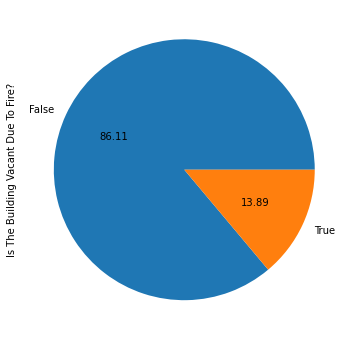

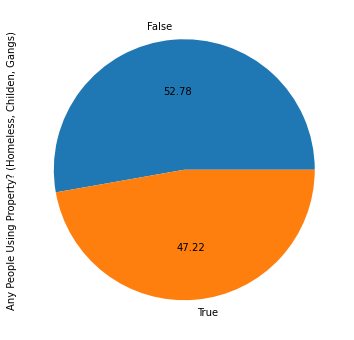

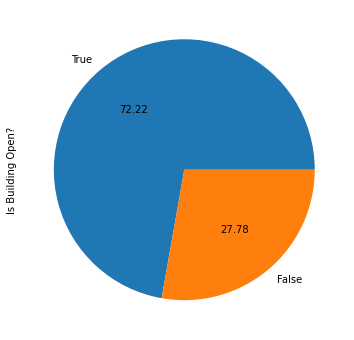

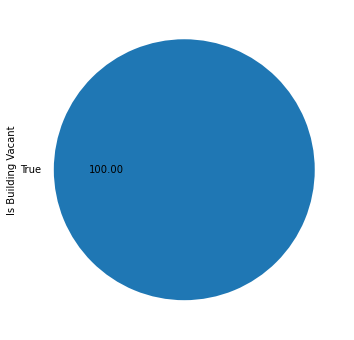

In [ ]:
for feature in features:
    plt.figure()
    south_deering[feature].value_counts().plot.pie(figsize=(6, 6), autopct='%.2f')

In [ ]:
open_buildings = vacancy_df[vacancy_df['Is Building Open?'] == True]
open_buildings['Entry Point if Open'].value_counts().nlargest(10)

FRONT                        1795
REAR                         1382
FRONT DOOR                    733
FRONT AND REAR                640
ALL AROUND                    389
REAR DOOR                     338
BACK DOOR                     256
FRONT AND BACK                204
ALL OVER                      202
FRONT/REAR DOORS, WINDOWS     183
Name: Entry Point if Open, dtype: int64

In [ ]:
with pd.ExcelWriter('cleaned_data.xlsx') as writer:  
    san_df.to_excel(writer, sheet_name='Sanitation Complaints')
    vacancy_df.to_excel(writer, sheet_name='Vacant Abandoned Buildings')

`The output of 'xlsx file' would be processed into further visulaization with Tableau`